# NB6 - Mapping hist and future streamflow simulation  forced by downscaled ESMs
- Only mapping river network with aggregated statistics


In [ ]:
%matplotlib inline  
import os
import sys
import glob
import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
from timeit import default_timer as timer

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy

from scripts.utility import AutoVivification
import scripts.colors as ccmap

print("\nThe Python version: %s.%s.%s" % sys.version_info[:3])
print(xr.__name__, xr.__version__)

## Dask
**Without Dask, loading netcdf takes much longer. This setup is a machine specific (here for NCAR Casper HPC). Please adjust this section, depending on your machine.**

In [ ]:
from dask_jobqueue import PBSCluster
from dask.distributed import Client
cluster = PBSCluster(processes=2, memory="100GB", queue='casper',
                  walltime='00:30:00')
cluster.scale(jobs=15)
client = Client(cluster)
client

## 1. settings

In [ ]:
main_path  = '/glade/campaign/ral/hap/mizukami/archive/pnw_hydrology/final_archive_v1'
geo_path   = os.path.join(main_path, 'ancillary_data','geospatial_data')
figure_path = 'NB6_figures'
os.makedirs(figure_path, exist_ok=True)

In [ ]:
gcm_runs = {
            'CanESM5':             {'scen':['hist', 'ssp245', 'ssp370', 'ssp585'], 'cmip':6},
            'CMCC-CM2-SR5':        {'scen':['hist', 'ssp245', 'ssp370', 'ssp585'], 'cmip':6},    
            'NorESM2-MM':          {'scen':['hist', 'ssp245', 'ssp370', 'ssp585'], 'cmip':6},
            'MIROC-ES2L':          {'scen':['hist', 'ssp245', 'ssp370', 'ssp585'], 'cmip':6},
            'MPI-M.MPI-ESM1-2-LR': {'scen':['hist', 'ssp245', 'ssp370', 'ssp585'], 'cmip':6},
            'CanESM2':             {'scen':['hist', 'rcp45',  'rcp85'], 'cmip':5},
            'CCSM4':               {'scen':['hist', 'rcp85'], 'cmip':5},
            'CMCC-CM':             {'scen':['hist', 'rcp45',  'rcp85'], 'cmip':5},
            'CNRM-CM5':            {'scen':['hist', 'rcp45',  'rcp85'], 'cmip':5},
            'MIROC5':              {'scen':['hist', 'rcp45',  'rcp85'], 'cmip':5},
            'MRI-CGCM3':           {'scen':['hist', 'rcp45',  'rcp85'], 'cmip':5},
           }

retro_runs = {
            'GMET':{'period':'control'}
            }

scens = {
         'hist':   {'time':slice('1975-01-01', '2004-12-31'), 'period':['control']},
         'ssp245': {'time':slice('2005-01-01', '2099-12-31'), 'period':['2040s','2080s']},
         'ssp370': {'time':slice('2005-01-01', '2099-12-31'), 'period':['2040s','2080s']},
         'ssp585': {'time':slice('2005-01-01', '2099-12-31'), 'period':['2040s','2080s']},
         'rcp45':  {'time':slice('2005-01-01', '2099-12-31'), 'period':['2040s','2080s']},
         'rcp85':  {'time':slice('2005-01-01', '2099-12-31'), 'period':['2040s','2080s']},
        }

periods = {
         'control':  {'time':slice('1980-10-01', '2004-09-30'), 'lc':'xkcd:blue'},
         '2040s':    {'time':slice('2029-10-01', '2060-09-30'), 'lc':'xkcd:orange'},
         '2080s':    {'time':slice('2069-10-01', '2099-09-30'), 'lc':'xkcd:magenta'},
          }

ensembles = {
             'cmip-hist':     {'cmip':[5,6], 'scen':['hist']},
             'cmip6-hist':    {'cmip':[6],   'scen':['hist']},
             'cmip5-hist':    {'cmip':[5],   'scen':['hist']},
             'cmip6-ssp245':  {'cmip':[6],   'scen':['hist', 'ssp245']},
             'cmip6-ssp585':  {'cmip':[6],   'scen':['hist', 'ssp585']},
             'cmip5-rcp85':   {'cmip':[5],   'scen':['hist', 'rcp85']},
             'cmip6':         {'cmip':[6],   'scen':['hist', 'ssp245', 'ssp370', 'ssp585']},
             'cmip5':         {'cmip':[5],   'scen':['hist', 'rcp45','rcp85']},
             'high-emission': {'cmip':[5,6], 'scen':['ssp585','rcp85']},
            }

sims   =  {**retro_runs, **gcm_runs}
gcm_names   = list(gcm_runs.keys())
retro_names = list(retro_runs.keys())
sim_names   = list(sims.keys())

# including variables
variables = {'streamflow':          {'scale':1,      'mon_agg':'mean'}, 
             'reachID':             {'scale':1,      'mon_agg':'None'}
            }

## 2. Load data

### 2.1 geospatial data

In [5]:
df_merit_flowline = gpd.read_file(os.path.join(geo_path,'rivEndoMERITpfaf_PNW.gpkg'))
# clean attributes
df_merit_flowline = df_merit_flowline.rename(columns={'COMID':'reachID'})
df_merit_flowline = df_merit_flowline.set_index('reachID')

### 2.2. Read mizuRoute outputs

Read mizuRoute daily output, annual mean, mean annual maximum, seasonal mean and store it in dictionaries

In [6]:
%%time
# get ESM forced streamflow simulation

def preprocess(ds):
    ds = ds[[*variables]]
    for var, meta in variables.items():
        ds[var] = ds[var]*meta['scale']
    return ds
    
# get GCM sim
ds_mizu_annual = AutoVivification()
ds_mizu_season = AutoVivification()

for gcm_name, meta in gcm_runs.items():
    for scen in meta['scen']:
        analysis_period = scens[scen]['time']

        if scen=='hist' and meta['cmip']==5: # for cmip5 historical period, use rcp85 data
            case = f'{gcm_name}_rcp85'
        elif scen=='hist' and meta['cmip']==6: # for cmip6 historical period, use ssp585 data
            case = f'{gcm_name}_ssp585'
        else: # for future period
            case = f'{gcm_name}_{scen}'
        
        nc=os.path.join(main_path, case, f'{case}_mizuRoute_daily.nc')
        ds_tmp = xr.open_mfdataset(nc, data_vars='minimal', parallel=True, preprocess=preprocess, chunks='auto')
        reach_id = ds_tmp['reachID'].load()
        
        for period in scens[scen]['period']:
            analysis_period = periods[period]['time']

            ds1 = ds_tmp.sel(time=analysis_period).mean(dim='time').load()
            ds1 = ds1.rename_vars({'streamflow':'ann_mean_q'})

            ds2 = ds_tmp.sel(time=analysis_period).resample(time='YS').max().mean(dim='time').load()
            ds2 = ds2.rename_vars({'streamflow':'ann_max_q'})
            
            ds_mizu_annual[gcm_name][scen][period] = xr.merge([ds1,ds2])
            
            ds_mizu_season[gcm_name][scen][period] = ds_tmp.sel(time=analysis_period).groupby("time.season").mean(dim="time").load()
            ds_mizu_season[gcm_name][scen][period]['reachID'] = ds_mizu_season[gcm_name][scen][period]['reachID'].isel(season=0, drop=True)
            
            # set coordinate variables
            ds_mizu_annual[gcm_name][scen][period] = ds_mizu_annual[gcm_name][scen][period].assign_coords(seg=reach_id) 
            ds_mizu_season[gcm_name][scen][period] = ds_mizu_season[gcm_name][scen][period].assign_coords(seg=reach_id) 
        print(f'{gcm_name}_{scen}')

CanESM5_hist
CanESM5_ssp245
CanESM5_ssp370
CanESM5_ssp585
CMCC-CM2-SR5_hist
CMCC-CM2-SR5_ssp245
CMCC-CM2-SR5_ssp370
CMCC-CM2-SR5_ssp585
NorESM2-MM_hist
NorESM2-MM_ssp245
NorESM2-MM_ssp370
NorESM2-MM_ssp585
MIROC-ES2L_hist
MIROC-ES2L_ssp245
MIROC-ES2L_ssp370
MIROC-ES2L_ssp585
MPI-M.MPI-ESM1-2-LR_hist
MPI-M.MPI-ESM1-2-LR_ssp245
MPI-M.MPI-ESM1-2-LR_ssp370
MPI-M.MPI-ESM1-2-LR_ssp585
CanESM2_hist
CanESM2_rcp45
CanESM2_rcp85
CCSM4_hist
CCSM4_rcp85
CMCC-CM_hist
CMCC-CM_rcp45
CMCC-CM_rcp85
CNRM-CM5_hist
CNRM-CM5_rcp45
CNRM-CM5_rcp85
MIROC5_hist
MIROC5_rcp45
MIROC5_rcp85
MRI-CGCM3_hist
MRI-CGCM3_rcp45
MRI-CGCM3_rcp85
CPU times: user 37.6 s, sys: 3.88 s, total: 41.5 s
Wall time: 3min 29s


In [10]:
%%time
# add retro forced streamflow simulation
for retro_name, meta in retro_runs.items():
    scen='hist'
    nclist=glob.glob(os.path.join(main_path, f'{retro_name}_hist','mizuRoute_daily.nc'))
    ds_tmp = xr.open_mfdataset(nc, data_vars='minimal', parallel=True, preprocess=preprocess, chunks='auto')

    for period in scens[scen]['period']:
        analysis_period = periods[period]['time']
        
        ds1 = ds_tmp.sel(time=analysis_period).mean(dim='time').load()
        ds1 = ds1.rename_vars({'streamflow':'ann_mean_q'})
    
        ds2 = ds_tmp.sel(time=analysis_period).resample(time='YS').max().mean(dim='time').load()
        ds2 = ds2.rename_vars({'streamflow':'ann_max_q'})
        
        ds_mizu_annual[retro_name][scen][period] = xr.merge([ds1,ds2])
        
        ds_mizu_season[retro_name][scen][period] = ds_tmp.sel(time=analysis_period).groupby("time.season").mean(dim="time").load()
        ds_mizu_season[retro_name][scen][period]['reachID'] = ds_mizu_season[retro_name][scen][period]['reachID'].isel(season=0, drop=True)
        
        # set coordinate variables
        ds_mizu_annual[retro_name][scen][period] = ds_mizu_annual[retro_name][scen][period].assign_coords(seg=reach_id) 
        ds_mizu_season[retro_name][scen][period] = ds_mizu_season[retro_name][scen][period].assign_coords(seg=reach_id) 

CPU times: user 834 ms, sys: 105 ms, total: 939 ms
Wall time: 5.74 s


emsemble mean of annual mean over period

In [11]:
ensemble_name='high-emission'

gcm_plots = {gcm: meta['scen'] for gcm, meta in gcm_runs.items() if meta['cmip'] in ensembles[ensemble_name]['cmip'] }

# -------------------
print('Computing ensemble mean of annual mean.....')
# -------------------

ds_ens_mean_annual = {}
count = 0 
for gcm_name, scen_list in gcm_plots.items():
    if count==0:
        ds_ens_mean_annual['control'] = ds_mizu_annual[gcm_name]['hist']['control']
    else:
        ds_ens_mean_annual['control'] = ds_ens_mean_annual['control'] + ds_mizu_annual[gcm_name]['hist']['control']
    count+=1
# emsemble mean
ds_ens_mean_annual['control'] = ds_ens_mean_annual['control']/count

count = 0 
for gcm_name, scen_list in gcm_plots.items():
    for scen in scen_list:
        if scen=='hist':
            continue
        if count==0:
            ds_ens_mean_annual['2040s']  = ds_mizu_annual[gcm_name][scen]['2040s']
            ds_ens_mean_annual['2080s']  = ds_mizu_annual[gcm_name][scen]['2080s']
        else:
            ds_ens_mean_annual['2040s']  = ds_ens_mean_annual['2040s'] + ds_mizu_annual[gcm_name][scen]['2040s']
            ds_ens_mean_annual['2080s']  = ds_ens_mean_annual['2080s'] + ds_mizu_annual[gcm_name][scen]['2080s']
        count+=1
        
# emsemble mean
ds_ens_mean_annual['2040s'] = ds_ens_mean_annual['2040s']/count
ds_ens_mean_annual['2080s'] = ds_ens_mean_annual['2080s']/count

Computing ensemble mean of annual mean.....


## Annual mean change

Each future period for each GCM and scenario

In [12]:
var_list = {
    'ann_mean_q': 'pdiff',
    'ann_max_q': 'pdiff',
}

ds_mizu_ann_mean_change = AutoVivification()
for gcm_name, sim_meta in gcm_runs.items():
    for scen in sim_meta['scen']: 
        for period in scens[scen]['period']:
            if period == 'hist':
                continue
            for var, method in var_list.items():
                ds_mizu_ann_mean_change[gcm_name][scen][period][var] = ds_mizu_annual[gcm_name][scen][period][var] - ds_mizu_annual[gcm_name]['hist']['control'][var]
                if method == 'pdiff':
                    ds_mizu_ann_mean_change[gcm_name][scen][period][var] = ds_mizu_ann_mean_change[gcm_name][scen][period][var]/ds_mizu_annual[gcm_name]['hist']['control'][var]*100

Each future period for one emsemble mean

In [13]:
ds_ens_mean_annual_change = AutoVivification()
for period in periods.keys():
    if period == 'control':
        continue
    for var, method in var_list.items():
        ds_ens_mean_annual_change[period][var] = ds_ens_mean_annual[period][var] - ds_ens_mean_annual['control'][var]
        if method == 'pdiff':
            ds_ens_mean_annual_change[period][var] = ds_ens_mean_annual_change[period][var]/ds_ens_mean_annual['control'][var]*100  

## Mapping

In [15]:
# some local plot setups

cm = {'general'  : mpl.colormaps['YlGnBu'],
      'diff1':     ccmap.cmap_summa_diff,
      'diff2':     ccmap.cmap_summa_swe_diff}

cbar_kwrgs = {"orientation":"horizontal", "shrink":0.75, "pad":0.03, 'extend':'both'}

style_kwargs = {'add_labels': False, 'xticks':[], 'yticks':[], 'cbar_kwargs': cbar_kwrgs}

segVar = {
    'ann_mean_q': {'name':'annual mean flow', 'vmin':20, 'vmax':1000, 'cm':cm['general'], 'extend':'both', 'unit':'m3/s',  **style_kwargs},
    'ann_max_q': {'name':'annual max flow', 'vmin':20, 'vmax':1000, 'cm':cm['general'], 'extend':'both', 'unit':'m3/s',  **style_kwargs},
         } 

segVar_diff = {
    'ann_mean_q': {'name':'annual mean flow', 'vmin':-60,  'vmax':60,  'cm':cm['diff1'], 'extend':'both', 'unit':'%', **style_kwargs},
    'ann_max_q': {'name':'annual max flow', 'vmin':-60,  'vmax':60,  'cm':cm['diff1'], 'extend':'both', 'unit':'%', **style_kwargs},
               } 

In [16]:
df_mizu = AutoVivification()
for gcm_name, _ in gcm_runs.items():    
    df_mizu[gcm_name] = df_merit_flowline
    for var, _ in segVar.items():
        df_var = ds_mizu_annual[gcm_name]['hist']['control'][var].to_dataframe()
        df_mizu[gcm_name] = df_mizu[gcm_name].merge(df_var,left_index=True, right_index=True)

In [17]:
df_mizu_diff = AutoVivification()
for gcm_name, meta in gcm_runs.items():
    for scen in meta['scen']:
        for period in scens[scen]['period']:
            if period == 'control':
                continue
            df_mizu_diff[gcm_name][scen][period] = df_merit_flowline
            for var, _ in segVar.items():
                df_var = ds_mizu_ann_mean_change[gcm_name][scen][period][var].to_dataframe()
                df_mizu_diff[gcm_name][scen][period] = df_mizu_diff[gcm_name][scen][period].merge(df_var, left_index=True, right_index=True)

In [18]:
def add_ylabel(ax, text, fontsize=12):
    return ax.text(-0.07, 0.55, text, va='center', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=fontsize)

### Individual GCM and scenario

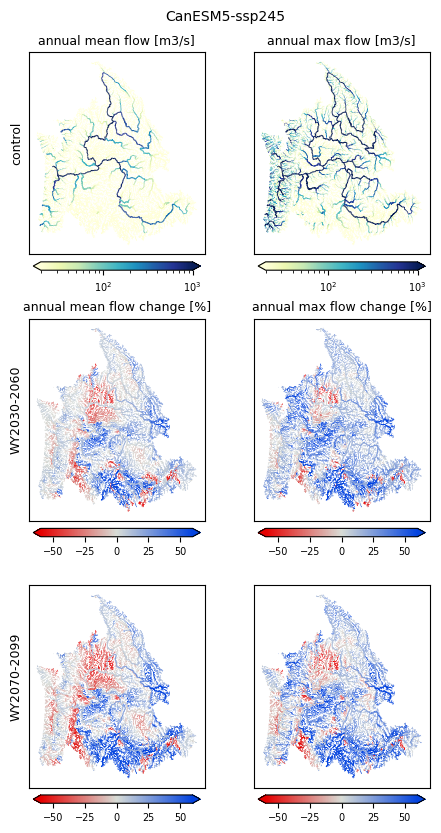

In [25]:
plot_case='CanESM5'
scen='ssp245'

nrows=3; ncols=2
fig1, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(4.65, 8.5), dpi=100)
plt.subplots_adjust(left=0.0275, bottom=0.0175, right=0.990, top=0.935, hspace=0.08, wspace=0.01)

for col, (var, _) in enumerate(segVar.items()):
    df_mizu[plot_case][df_mizu[plot_case]['order']<=3].plot(ax=ax[0, col], column=var, lw=0.3, cmap=segVar[var]['cm'], norm=mpl.colors.LogNorm(vmin=segVar[var]['vmin'], vmax=segVar[var]['vmax']), legend=False)
    df_mizu[plot_case][df_mizu[plot_case]['order']==4].plot(ax=ax[0, col], column=var, lw=0.5, cmap=segVar[var]['cm'], norm=mpl.colors.LogNorm(vmin=segVar[var]['vmin'], vmax=segVar[var]['vmax']), legend=False)
    df_mizu[plot_case][df_mizu[plot_case]['order']>=5].plot(ax=ax[0, col], column=var, lw=0.7, cmap=segVar[var]['cm'], norm=mpl.colors.LogNorm(vmin=segVar[var]['vmin'], vmax=segVar[var]['vmax']), legend=False)

    df_plot_diff = df_mizu_diff[plot_case][scen]
    df_plot_diff['2040s'][df_plot_diff['2040s']['order']<=3].plot(ax=ax[1, col], column=var, lw=0.3, cmap=segVar_diff[var]['cm'], vmin=segVar_diff[var]['vmin'], vmax=segVar_diff[var]['vmax'], legend=False)
    df_plot_diff['2040s'][df_plot_diff['2040s']['order']==4].plot(ax=ax[1, col], column=var, lw=0.5, cmap=segVar_diff[var]['cm'], vmin=segVar_diff[var]['vmin'], vmax=segVar_diff[var]['vmax'], legend=False)
    df_plot_diff['2040s'][df_plot_diff['2040s']['order']>=5].plot(ax=ax[1, col], column=var, lw=0.7, cmap=segVar_diff[var]['cm'], vmin=segVar_diff[var]['vmin'], vmax=segVar_diff[var]['vmax'], legend=False)

    df_plot_diff['2080s'][df_plot_diff['2080s']['order']<=3].plot(ax=ax[2, col], column=var, lw=0.3, cmap=segVar_diff[var]['cm'], vmin=segVar_diff[var]['vmin'], vmax=segVar_diff[var]['vmax'], legend=False)
    df_plot_diff['2080s'][df_plot_diff['2080s']['order']==4].plot(ax=ax[2, col], column=var, lw=0.5, cmap=segVar_diff[var]['cm'], vmin=segVar_diff[var]['vmin'], vmax=segVar_diff[var]['vmax'], legend=False)
    df_plot_diff['2080s'][df_plot_diff['2080s']['order']>=5].plot(ax=ax[2, col], column=var, lw=0.7, cmap=segVar_diff[var]['cm'], vmin=segVar_diff[var]['vmin'], vmax=segVar_diff[var]['vmax'], legend=False)

    ax[0,col].set_xticks([])
    ax[0,col].set_yticks([])
    ax[0,col].set_title('%s [%s]'%(segVar[var]['name'], segVar[var]['unit']), fontsize=9);
    ax[1,col].set_title('%s change [%s]'%(segVar_diff[var]['name'], segVar_diff[var]['unit']), fontsize=9);

    points = ax[0,col].collections[-1]
    cbar = plt.colorbar(points, ax=ax[0,col], **cbar_kwrgs);
    cbar.ax.tick_params(labelsize=7)
    
    points = ax[1,col].collections[-1]
    cbar = plt.colorbar(points, ax=ax[1,col], **cbar_kwrgs);
    cbar.ax.tick_params(labelsize=7)
    
    points = ax[2,col].collections[-1]
    cbar = plt.colorbar(points, ax=ax[2,col], **cbar_kwrgs);
    cbar.ax.tick_params(labelsize=7)
    
add_ylabel(ax[0, 0], 'control', fontsize=9)
add_ylabel(ax[1, 0], 'WY2030-2060', fontsize=9)
add_ylabel(ax[2, 0], 'WY2070-2099', fontsize=9)
    
fig1.suptitle(f'{plot_case}-{scen}', fontsize=10, y=0.985);
plt.savefig(os.path.join(figure_path, f'Fig1_river_annual_map_{plot_case}_{scen}.png'), dpi=300)

### ensemble

In [20]:
df_ens_mean = df_merit_flowline
for var, _ in segVar.items():
    df_var = ds_ens_mean_annual['control'][var].to_dataframe()
    df_ens_mean = df_ens_mean.merge(df_var,left_index=True, right_index=True)
    df_ens_mean = df_ens_mean[df_ens_mean['order']>1]

df_ens_mean_diff = AutoVivification()
for period in periods.keys():
    if period == 'control':
        continue
    df_ens_mean_diff[period] = df_merit_flowline
    for var, _ in segVar.items():
        df_var = ds_ens_mean_annual_change[period][var].to_dataframe()
        df_ens_mean_diff[period] = df_ens_mean_diff[period].merge(df_var, left_index=True, right_index=True)
        df_ens_mean_diff[period] = df_ens_mean_diff[period][df_ens_mean_diff[period]['order']>1]

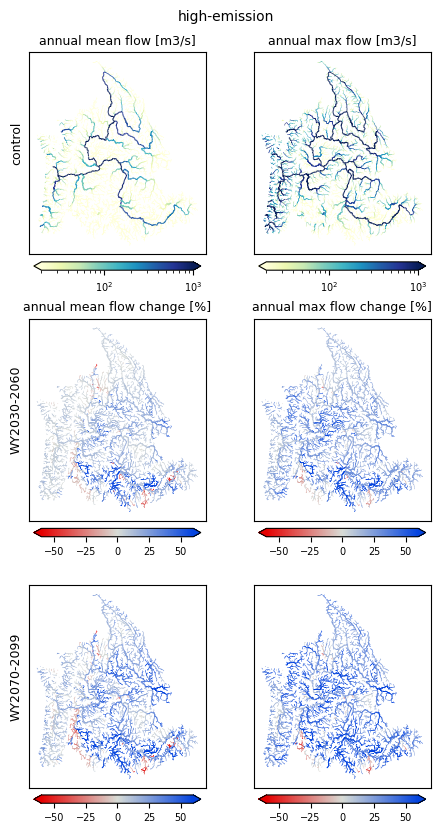

In [21]:
nrows=3; ncols=2
fig1, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(4.65, 8.5), dpi=100)
plt.subplots_adjust(left=0.0275, bottom=0.0175, right=0.990, top=0.935, hspace=0.08, wspace=0.01)

for col, (var, _) in enumerate(segVar.items()):
    df_ens_mean[df_ens_mean['order']<=3].plot(ax=ax[0, col], column=var, lw=0.3, cmap=segVar[var]['cm'], norm=mpl.colors.LogNorm(vmin=segVar[var]['vmin'], vmax=segVar[var]['vmax']), legend=False)
    df_ens_mean[df_ens_mean['order']==4].plot(ax=ax[0, col], column=var, lw=0.5, cmap=segVar[var]['cm'], norm=mpl.colors.LogNorm(vmin=segVar[var]['vmin'], vmax=segVar[var]['vmax']), legend=False)
    df_ens_mean[df_ens_mean['order']>=5].plot(ax=ax[0, col], column=var, lw=0.7, cmap=segVar[var]['cm'], norm=mpl.colors.LogNorm(vmin=segVar[var]['vmin'], vmax=segVar[var]['vmax']), legend=False)
    
    df_ens_mean_diff['2040s'][df_ens_mean_diff['2040s']['order']<=3].plot(ax=ax[1, col], column=var, lw=0.3, cmap=segVar_diff[var]['cm'], vmin=segVar_diff[var]['vmin'], vmax=segVar_diff[var]['vmax'], legend=False)
    df_ens_mean_diff['2040s'][df_ens_mean_diff['2040s']['order']==4].plot(ax=ax[1, col], column=var, lw=0.5, cmap=segVar_diff[var]['cm'], vmin=segVar_diff[var]['vmin'], vmax=segVar_diff[var]['vmax'], legend=False)
    df_ens_mean_diff['2040s'][df_ens_mean_diff['2040s']['order']>=5].plot(ax=ax[1, col], column=var, lw=0.7, cmap=segVar_diff[var]['cm'], vmin=segVar_diff[var]['vmin'], vmax=segVar_diff[var]['vmax'], legend=False)

    df_ens_mean_diff['2080s'][df_ens_mean_diff['2080s']['order']<=3].plot(ax=ax[2, col], column=var, lw=0.3, cmap=segVar_diff[var]['cm'], vmin=segVar_diff[var]['vmin'], vmax=segVar_diff[var]['vmax'], legend=False)
    df_ens_mean_diff['2080s'][df_ens_mean_diff['2080s']['order']==4].plot(ax=ax[2, col], column=var, lw=0.5, cmap=segVar_diff[var]['cm'], vmin=segVar_diff[var]['vmin'], vmax=segVar_diff[var]['vmax'], legend=False)
    df_ens_mean_diff['2080s'][df_ens_mean_diff['2080s']['order']>=5].plot(ax=ax[2, col], column=var, lw=0.7, cmap=segVar_diff[var]['cm'], vmin=segVar_diff[var]['vmin'], vmax=segVar_diff[var]['vmax'], legend=False)

    ax[0,col].set_xticks([])
    ax[0,col].set_yticks([])
    ax[0,col].set_title('%s [%s]'%(segVar[var]['name'], segVar[var]['unit']), fontsize=9);
    ax[1,col].set_title('%s change [%s]'%(segVar_diff[var]['name'], segVar_diff[var]['unit']), fontsize=9);

    points = ax[0,col].collections[-1]
    cbar = plt.colorbar(points, ax=ax[0,col], **cbar_kwrgs);
    cbar.ax.tick_params(labelsize=7)
    
    points = ax[1,col].collections[-1]
    cbar = plt.colorbar(points, ax=ax[1,col], **cbar_kwrgs);
    cbar.ax.tick_params(labelsize=7)
    
    points = ax[2,col].collections[-1]
    cbar = plt.colorbar(points, ax=ax[2,col], **cbar_kwrgs);
    cbar.ax.tick_params(labelsize=7)
    
add_ylabel(ax[0, 0], 'control', fontsize=9)
add_ylabel(ax[1, 0], 'WY2030-2060', fontsize=9)
add_ylabel(ax[2, 0], 'WY2070-2099', fontsize=9)
    
fig1.suptitle(f'{ensemble_name}', fontsize=10, y=0.985);
plt.savefig(os.path.join(figure_path, f'Fig2_river_annual_map_{ensemble_name}.png'), dpi=300)